## Revisiting Data Selection: How much and what data is most beneficial?

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [5]:
import os
os.chdir("../")

In [6]:
%load_ext autoreload
%autoreload 2

We have a large population of synthetic data. How much and which data is most beneficial?

In [4]:
from src.sync_data.population import Population
import numpy as np
import pandas as pd
def init_population_from_dump(df, labeled=True, use_evidence=None):
    """ Initialize the population with the correct scores. """
    mypopulation = Population()
    if use_evidence is None:
        evidence_items = df["tag_0"].unique()
    else:
        evidence_items = use_evidence

    for evidence in evidence_items:
        if labeled:
            for label in [0, 1]:
                index = (df["tag_0"] == evidence) & (df["tag_1"] == label)
                use_claims = df[index]["sample"].values
                p_init = df[index]["p_init"].values
                p_agree = df[index]["p_agree"].values
                if label == 1:
                    p_init[p_init < 0.5] = 0.5
                else:
                    p_init[p_init > 0.5] = 0.5
                mypopulation[(evidence, label)] = use_claims, np.zeros(len(use_claims)), p_agree, p_init
        else:
            index = (df["evidence"] == evidence)
            mypopulation[evidence] = df[index]["claim"].values
    return mypopulation

In [5]:
from src.scripts.script_utils import get_datasets
from src.utils.data_utils import perform_query_integration


In [6]:
run = "c_opt_indep_ragtqa_nosel2"

In [7]:
org_data_train, org_data_test = get_datasets("ragtruth", group="QA")
querymode = "queryonly"
synth_data_train = pd.read_csv(f"runs/{run}/data_iteration_0_noselect.csv")
data_population = init_population_from_dump(synth_data_train)
org_data_train.df = perform_query_integration(org_data_train.df, mode=querymode)
org_data_test.df = perform_query_integration(org_data_test.df, mode=querymode)

Local files for RAGTruth not found. Falling back to S3...
891
Local files for RAGTruth not found. Falling back to S3...
882


In [8]:
list_evidence = synth_data_train.tag_0.unique()

In [9]:
from src.scripts.script_utils import init_population_from_df

In [10]:
from src.sync_data.evaluators import PopulationWithEmbeddings

src.cross_encoder_model.my_evaluator


In [11]:
pop_target = PopulationWithEmbeddings(init_population_from_df(org_data_train.df, labeled=False, use_evidence=list_evidence))

838


/home/ubuntu/DomainAdaptationForFactualConsistencyDetection/SyntheticData/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 838/838 [00:20<00:00, 40.33it/s]


In [12]:
len(synth_data_train)

46928

In [13]:
len(pop_target)

4891

In [14]:
data_population = PopulationWithEmbeddings(data_population)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1676/1676 [02:03<00:00, 13.58it/s]


In [15]:
from src.sync_data.combinatorial_optimization import SGDOptimizationSelector, IndependentSelector

In [16]:
myselector = IndependentSelector(pop_target, target_radius=0.2, source_radius=0.16, label_cert_weight=20.0)

In [17]:
from src.sync_data.evaluators import NLIFinetuningEvaluation
eval_models = ["tasksource_v1"]
evaluators_other ={}
for model_str in eval_models:
    evaluators_other[model_str] = NLIFinetuningEvaluation(org_data_test, target_model_str=model_str,
                                                             num_epochs=1, device="cuda", batch_size=2)

In [18]:
def run_evaluators(eval_list: dict, current_w_embed: Population):
    """ Perform evaluation for multiple evaluators. """
    res = {}
    for key, eval_obj in eval_list.items():
        res[key] = eval_obj(current_w_embed, None)
        print(f"Eval result on {key}")
        print(res[key])
    return res

In [24]:
k=0.02

In [25]:
print("computing penalties.")
penalty_dict = {}
for t in data_population.tags:
    penalty_dict[t] = myselector._compute_sample_penalties(data_population, t)

computing penalties.


In [ ]:
import torch
print(f"Selecting {k} ...")
n_total = int(k * len(penalty_dict))
## stratified
res_selection = {key: -penalty_dict[key].numpy() for key in penalty_dict}
if k < 1.0:
    val_list, idx_list, labels = [], [], []
    for key in penalty_dict:
        val, idx = torch.min(penalty_dict[key], dim=-1)
        val_list.append(val)
        idx_list.append(idx)
        labels.append(key[1])
    selected_batches0 = torch.argsort(torch.stack([val for val, lab in zip(val_list, labels) if lab==0]))[:n_total].numpy()
    selected_batches1 = torch.argsort(torch.stack([val for val, lab in zip(val_list, labels) if lab==1]))[:n_total].numpy()
    print(selected_batches0)
    arr_list = []
    l0cnt, l1cnt = 0, 0
    for key in penalty_dict:
        res_all = torch.zeros(len(penalty_dict[key]))
        if key[1] == 0 and l0cnt in selected_batches0:
            res_all[idx_list[l0cnt]] = 1
        if key[1] == 1 and l1cnt in selected_batches1:
            res_all[idx_list[l1cnt]] = 1
        if key[1] == 0:
            l0cnt += 1
        else:
            l1cnt += 1
        arr_list.append(res_all)
    use_idx = torch.cat(arr_list)
    print(use_idx.shape, torch.sum(use_idx))
    res_selection_dict = create_overall_topk_selection_dict(data_population, use_idx)
    current_w_embed = data_population.get_indexed_subpopulation(res_selection_dict)
    print(current_w_embed.to_dataframe()["tag_1"].mean())
else:
    res_selection_dict = create_topk_selection_dict(data_population, res_selection, k)
    current_w_embed = data_population.get_indexed_subpopulation(res_selection_dict)

print("size strat", len(current_w_embed))
eval_out_strat[k] = run_evaluators(evaluators_other, current_w_embed)
#json.dump(eval_out_strat, open(f"runs/{run}/eval_select_strat{lrlog}.json", "w"))

## First try stratified vs non-stratified selection

In [2]:
penalty_dict = {}
for t in data_population.tags:
    penalty_dict[t] = myselector._compute_sample_penalties(data_population, t)

NameError: name 'data_population' is not defined

In [3]:
len(penalty_dict)

0

In [89]:
def create_topk_selection_dict(popu, res_select, n_select=16):
    selection_dict = {}
    for t in popu.tags:
        selection_dict[t] = np.argsort(-res_select[t])[:n_select]
    return selection_dict

In [22]:
def create_overall_topk_selection_dict(popu, use_idx):
    selection_dict = {}
    idx = 0
    for t in popu.tags:
        sz = len(popu[t])
        if len(use_idx[idx:idx+sz].nonzero().flatten().numpy()) > 0:
            selection_dict[t] = use_idx[idx:idx+sz].nonzero().flatten().numpy()
        idx+=sz
    return selection_dict


In [31]:
use_idx[10:20].nonzero().flatten()

tensor([], dtype=torch.int64)

In [91]:
def create_overall_topk_selection_dict(popu, use_idx):
    selection_dict = {}
    idx = 0
    for t in popu.tags:
        sz = len(popu[t])
        selection_dict[t] = use_idx[idx:idx+sz].nonzero().flatten().numpy()
        idx+=sz
    return selection_dict

In [92]:
num_select = np.arange(12)*5+1

In [7]:
eval_out_strat = {}
eval_out_nonstrat = {}
import torch
for k in num_select:
    print(k)
    ## stratified
    res_selection = {key: -penalty_dict[key].numpy() for key in penalty_dict}
    res_selection_dict = create_topk_selection_dict(data_population, res_selection, k)
    current_w_embed = data_population.get_indexed_subpopulation(res_selection_dict)
    print("size strat", len(current_w_embed))
    eval_out_strat[k] = run_evaluators(evaluators_other, current_w_embed)
    
    ## non-stratified
    n_total = k*len(penalty_dict)
    all_pens = torch.cat([p for p in penalty_dict.values()])
    print(all_pens.shape)
    use_idx = torch.zeros(len(data_population))
    use_idx[all_pens.argsort(dim=-1)[:n_total]]=1
    nonstrat_selection_dict = create_overall_topk_selection_dict(data_population, use_idx)
    current_w_embed_ns = data_population.get_indexed_subpopulation(nonstrat_selection_dict)
    print("size nonstrat", len(current_w_embed_ns))
    eval_out_nonstrat[k] = run_evaluators(evaluators_other, current_w_embed_ns)

NameError: name 'num_select' is not defined

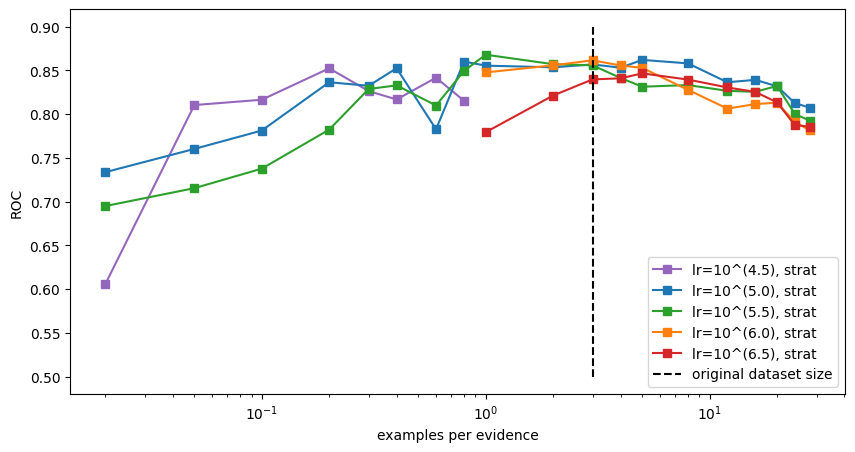

In [13]:
run = "c_opt_indep_ragtqa_nosel2-v2"
import numpy as np
import json
import matplotlib.pyplot as plt
roc_list = []
per_sample_list = []
for logs, c in zip([4.5, 5.0, 5.5, 6.0, 6.5], ["tab:purple", "tab:blue", "tab:green", "tab:orange", "tab:red"]):
    eval_out = json.load(open(f"runs/{run}/eval_select_strat-{logs}.json"))
    x = np.array([float(x) for x in eval_out.keys()])
    y = np.array(([k["tasksource_v1"]["roc"] for k in eval_out.values()]))
    order = np.argsort(x)
    plt.plot(np.sort(x), y[order], "-s", c=c, label=f"lr=10^({logs}), strat")
    roc_list.append( y[order])
    per_sample_list.append(np.sort(x))
    #eval_out_non = json.load(open(f"runs/{run}/eval_select_nonstrat-{logs}.json"))
    #x = np.array([float(x) for x in eval_out_non.keys()])
    #order = np.argsort(x)
    #y = np.array(([k["tasksource_v1"]["roc"] for k in eval_out_non.values()]))
    #plt.plot(np.sort(x), y[order], "--s", c=c)
    #roc_list.append( y[order])
    #per_sample_list.append(np.sort(x))
plt.plot([3,3], [0.5, 0.9], "--k", label="original dataset size")
plt.gca().set_xscale('log')
#plt.xticks(x)
plt.xlabel("examples per evidence")
plt.ylabel("ROC")
plt.gcf().set_size_inches(10,5)
plt.legend()
roc_list = np.concatenate(roc_list)
per_sample_list = np.concatenate(per_sample_list)

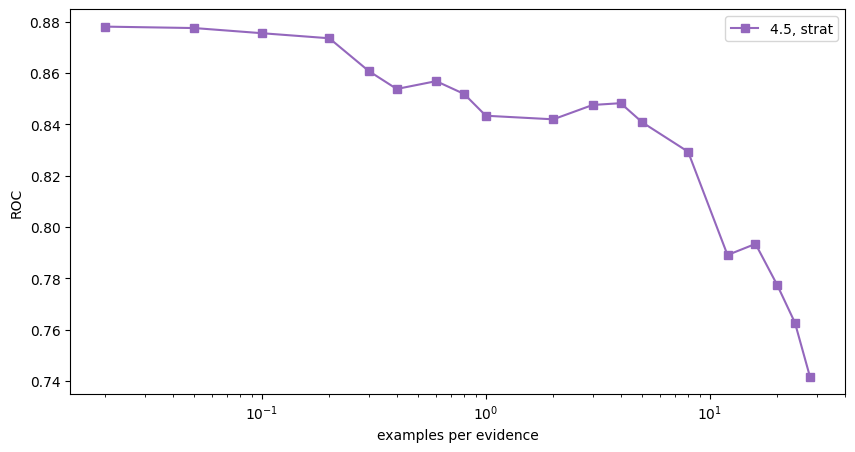

In [82]:
run = "c_opt_indep_ragtqa_nosel2"
model="vectara_v2"
import numpy as np
import json
import matplotlib.pyplot as plt
roc_list = []
per_sample_list = []
for logs, c in zip([4.5], ["tab:purple"]):
    eval_out = json.load(open(f"runs/{run}/eval_select_strat-{logs}.json"))
    x = np.array([float(x) for x in eval_out.keys()])
    y = np.array(([k[model]["roc"] for k in eval_out.values()]))
    order = np.argsort(x)
    plt.plot(np.sort(x), y[order], "-s", c=c, label=f"{logs}, strat")
    roc_list.append( y[order])
    per_sample_list.append(np.sort(x))
    eval_out_non = json.load(open(f"runs/{run}/eval_select_nonstrat-{logs}.json"))
    x = np.array([float(x) for x in eval_out_non.keys()])
    order = np.argsort(x)
    y = np.array(([k[model]["roc"] for k in eval_out_non.values()]))
    #plt.plot(np.sort(x), y[order], "--s", c=c)
    roc_list.append( y[order])
    per_sample_list.append(np.sort(x))
plt.gca().set_xscale('log')
#plt.xticks(x)
plt.xlabel("examples per evidence")
plt.ylabel("ROC")
plt.gcf().set_size_inches(10,5)
plt.legend()
roc_list = np.concatenate(roc_list)
per_sample_list = np.concatenate(per_sample_list)

## Hyperparameters

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
model="tasksource"
run = "c_opt_indep_ragtqa_nosel2-v2"
res = json.load(open(f"runs/{run}/hyperopt_{model}.json"))

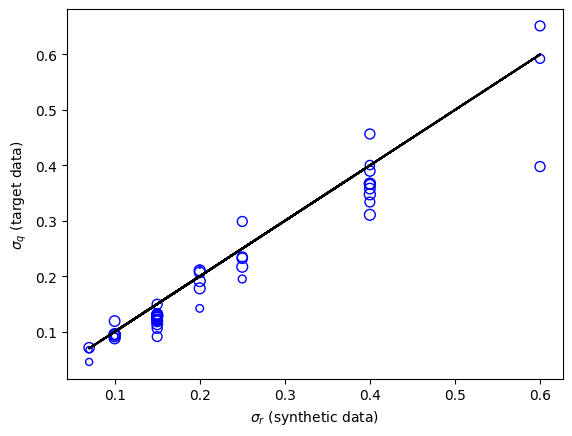

In [7]:
x1="source_radius"
x2="target_radius"
metric = "roc"
x = np.array([float(item["parameters"][x1]) for item in res])
y = np.array([float(item["parameters"][x2]) for item in res])
z = np.array([float(item[metric]) for item in res])
z = 500*(z-np.min(z))
plt.plot(x, x, "--k")
plt.xlabel(f"$\sigma_r$ (synthetic data)")
plt.ylabel(f"$\sigma_q$ (target data)")
plt.scatter(x,y,z, marker="o", facecolors='none', edgecolors='b')

Text(0, 0.5, 'loss_util_weight')

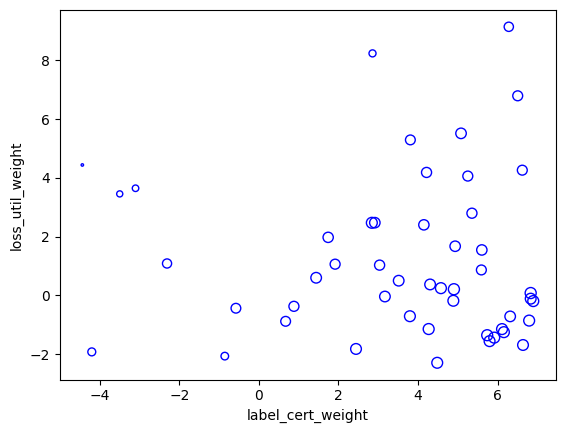

In [8]:
import json
x1="label_cert_weight"
x2="loss_util_weight"
model="tasksource"
metric = "roc"

res = json.load(open(f"runs/{run}/hyperopt_{model}.json"))
x = np.array([np.log(float(item["parameters"][x1])) for item in res])
y = np.array([np.log(float(item["parameters"][x2])) for item in res])
z = np.array([float(item[metric]) for item in res])
z = 500*(z-np.min(z))
plt.scatter(x,y,z, marker="o", facecolors='none', edgecolors='b')
plt.xlabel(x1)
plt.ylabel(x2)

In [9]:
res[np.argmax(z)]

{'f1': 0.865271068169619,
 'accuracy': 0.8058489033306255,
 'precision': 0.8011928429423459,
 'recall': 0.94049008168028,
 'roc': 0.8429495379354669,
 'pos_avg': 0.877975262057517,
 'neg_avg': 0.3785398717210145,
 'bacc': 0.745472953157077,
 'parameters': {'target_radius_ratio': 0.8699615163052637,
  'source_radius': 0.4,
  'label_cert_weight': 134.7247816073547,
  'loss_util_weight': 1.230115976244035,
  'target_radius': 0.3479846065221055}}

In [68]:
df_test = load_ragtruth(split="test")

Local files for RAGTruth not found. Falling back to S3...


In [69]:
len(df_test)

1987

In [77]:
df_train = get_ragtruth_dataset(split="val")

Local files for RAGTruth not found. Falling back to S3...


In [78]:
len(df_train)

3744

In [72]:
df_val

,id,source_id,model,temperature,labels,split,quality,response,task_type,source,source_info,prompt
0,0,15592,gpt-4-0613,0.70,[],val,good,The Anne Frank House has revealed that Anne Fr...,Summary,CNN/DM,"Seventy years ago, Anne Frank died of typhus i...",Summarize the following news within 116 words:...
1,1,15592,gpt-3.5-turbo-0613,0.70,[],val,good,New research released by the Anne Frank House ...,Summary,CNN/DM,"Seventy years ago, Anne Frank died of typhus i...",Summarize the following news within 116 words:...
2,2,15592,mistral-7B-instruct,0.70,"[{'start': 636, 'end': 653, 'text': 'February ...",val,good,New research conducted by the Anne Frank House...,Summary,CNN/DM,"Seventy years ago, Anne Frank died of typhus i...",Summarize the following news within 116 words:...
3,3,15592,llama-2-7b-chat,0.70,"[{'start': 693, 'end': 754, 'text': 'Anne's di...",val,good,Here is a summary of the article in 115 words ...,Summary,CNN/DM,"Seventy years ago, Anne Frank died of typhus i...",Summarize the following news within 116 words:...
4,4,15592,llama-2-13b-chat,0.70,[],val,good,"Seventy years ago, Anne Frank died of typhus i...",Summary,CNN/DM,"Seventy years ago, Anne Frank died of typhus i...",Summarize the following news within 116 words:...
...,...,...,...,...,...,...,...,...,...,...,...,...
17785,17785,12460,gpt-3.5-turbo-0613,0.70,[],val,good,Eating tomatoes can provide nutrition benefits...,QA,MARCO,{'question': 'what are nutrition benefits eati...,Briefly answer the following question:\nwhat a...
17786,17786,12460,mistral-7B-instruct,0.70,"[{'start': 193, 'end': 223, 'text': 'and suppo...",val,good,"Based on the given passages, it appears that e...",QA,MARCO,{'question': 'what are nutrition benefits eati...,Briefly answer the following question:\nwhat a...
17787,17787,12460,llama-2-7b-chat,0.70,"[{'start': 634, 'end': 690, 'text': 'reducing ...",val,good,"Based on the provided passages, here are the n...",QA,MARCO,{'question': 'what are nutrition benefits eati...,Briefly answer the following question:\nwhat a...
17788,17788,12460,llama-2-13b-chat,1.00,[],val,good,"Based on the provided passages, here are the n...",QA,MARCO,{'question': 'what are nutrition benefits eati...,Briefly answer the following question:\nwhat a...


In [108]:
import src.sync_data.initial_generators as generators

In [110]:
mycls = getattr(generators, "FromFile")

In [111]:
mycls()